# INM702 Coursework Task 1 
### Aaron Mir (Student Number: 160001207)
#### 20/12/20

<img src="Task1(1).jpg" alt="Task1(1)" width="700"/>
<img src="Task1(2).jpg" alt="Task1(2)" width="700"/>
<img src="Task1(3).jpg" alt="Task1(3)" width="700"/>
<img src="Task1(4).jpg" alt="Task1(4)" width="700"/>


The first task tests your Python skills. You need to develop a simple game consisting of a rectangular grid (of size height x width) where each cell has a random integer value between 0 and 9. An agent starts at the upper-left corner of the grid and must  reach the lower-right corner of the grid as fast as possible. You can implement one of the two (or both, for no extra point) game modes:

    • The time spent on a cell is the number on this cell
    • The time spent on a cell is the absolute of the difference between the previous cell the agent was on and the current cell it is on

In order to solve this problem, you will provide 3 algorithms:

    • A first baseline of your choosing. E.g. it can be any search algorithm, or an algorithm using heuristics. 
    It doesn’t have to perform fast or well, but  should be better than random movements.
    • Dijkstra's algorithm
    • Ant colony optimization algorithm

You should describe the algorithms and compare them. Are they always solving the problem? How long do they take depending on the size of the maze?


In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation
import numpy as np
import torch 
import torchvision as tv
import random
np.set_printoptions(threshold=sys.maxsize)
np.random.seed(1)

print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {tv.__version__}")
#Use assert to test functions

#import sys
#from __future__ import division

Python: 3.8.1 (tags/v3.8.1:1b293b6, Dec 18 2019, 23:11:46) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.18.1
PyTorch Version: 1.6.0+cu101
Torchvision Version: 0.7.0+cu101


In [21]:
class Agent():
    '''A class to represent an agent. The goal of the agent is to move along the grid from the upper left corner to the lower right corner using the shortest path possible.'''

    def __init__ (self, name, maze = None):
        '''ADD ARGS EXPLANATION'''
        self.name = name
        self.maze = maze
        #self.i, self.j = 0, 0 # curr_position used to be [self.i, self.j] but that is redundant at least for the naive approach
        self.curr_position = []         # this changes according to the current position of the agent after choosing a path
        self.position_history = []      # holds the history of agent positions, helps verify
        self.options = []               # holds the time values of paths found
        self.option_coords = []         # holds the coordinates of each cell in those paths
        self.isFinished = False         # changes if agent reaches position bottom right cell, helps verify
        #self.marker = plt.Circle((self.__x + 0.5, self.__y + 0.5), radius=0.4, fc='y')
 
    def recursive_path(self, maze, row, col, paths, coords): 
         '''Recursively finds all the possible paths the agent can take to get to the bottom right cell by exploring all paths by moving down and right in the array. Then adds the times spent on each cell for each path and will traverse the path that has the lowest overall time. The current position of the agent is then changed after the comparison is made between different paths.'''                  

        paths.append(maze[row][col])            # append the time value of the starting cell to path list
        coords.append((row, col))               # append the the indexes of that time value coords list
        if row == len(maze) - 1:                # if the current row is equal to the height of the maze - 1 
            for i in range(col, len(maze[0])):  # for every column from the current column to the edge of the grid going across
                paths.append(maze[row][i])      # append all the time values into the path list depending on which row it is currently on
                coords.append((row, i))         # append all the indexes of those times into the coordinate list of tuples depending on which row it is currently on
            self.options.append(paths)          # append the possible options to the agent attribute 'options'
            self.option_coords.append(coords)   # append the coordinates of those possible options to the agent attribute 'option_coords'
            return 

        if col == len(maze[0]) - 1:             # if the current column is equal to the width of the maze - 1 eg. 3 - 1 = 2
            for i in range(row, len(maze)):     # for every row from the current row to the edge of the grid going down
                paths.append(maze[i][col])      # put all the time values into the path list depending on which column it is currently on
                coords.append((i, col))         # put all the indexes of those times into the coordinate list of tuples depending on which column it is currently on
            self.options.append(paths)
            self.option_coords.append(coords)
            return
        all_possible_paths_and_coords(row + 1, col, paths[:], coords[:], maze) # recursion for each row 
        all_possible_paths_and_coords(row, col + 1, paths[:], coords[:], maze) # recursion for each column       
        
        sum_time_vals = np.zeros(len(self.options), dtype=int) # initialising an array of all the total times for each path
        for i in range(0, len(self.options)):
            sum_time_vals[i] = sum(self.options[i])
        chosen_path = list(sum_time_vals).index(np.min(sum_time_vals)) # returns index of the shortest path in 'options' so self.options[chosen_path] contains the path chosen 
        
        for i in range(len(option_coords[chosen_path])):            # changes the agents current position according to this path - signifies movement         
            self.curr_position = self.options_coords[chosen_path][i] 
            # NEED TO ADD SOME ANIMATION TO THE PLOT FUNCTION OF THE MAZE TO SHOW AGENT MOVING AS THE CURRENT POSITION CHANGES

        self.position_history.append(option_coords[chosen_path])    # indicates which cells have been visited by the agent during this traversal i.e. the chosen path
        
        if self.curr_position == self.options_coords[chosen_path][-1]: # verifies that the agent has reached the bottom right
            self.isFinished == True 
        else:
            self.isFinished == False
            print("An error has occurred.")     

 def antcol_path(self, maze, n_ants, alpha=1, beta=1):
        
      pass                                 

'''  
    def dijkstra_path(self): # HAS TO LOOK AT THE GRID AS A WHOLE AND FIND THE PATH BEFORE TAKING IT
        # Can convert the maze to a graph using dictionary
        # Alternatively, each cell in the grid can represents a vertex and neighbor cells adjacent vertices. Thus, not making an explicit graph from these cells instead using the grid as it is in my dijkstra’s algorithm. 
        # Will also outline the finishing point and state that the agent shouldn't go to cells it has already visited by using a boolean version of the maze where if a cell has been visited it will show true
        pass
'''

In [26]:
class IntMaze():
    '''A class to represent a maze. A maze in this scenario is a 2D (height x width) grid where each cell has a number associated to it. This cell number indicates the time an agent spends on a cell. There are 2 game modes. Game mode 1 is where the time spent on a cell is the number on this cell. Game mode 2 is where the time spent on a cell is the absolute of the difference between the previous cell the agent was on and the current cell it is on. '''

    def __init__ (self, height, width, mode, alg, agent):  
        self.height = height
        self.width = width
        self.mode = mode
        self.agent = agent
        self.alg = alg
        self.path_find_type = {'Recursive': 0, 'Dijkstra': 1, 'Ant Colony': 2}
    
    def create_maze(self): # generates the grid/map
        return np.array(np.random.randint(0, 10, size = (self.height, self.width)))

    def start_game(self):
        self.maze = self.create_maze() #create the grid/maze
        self.agent.maze = self # add agent to the maze/environment
        if self.mode == 1:
            if self.path_find_type[self.alg] == 0: # Recursive approach
                self.agent.recursive_path()
            elif self.path_find_type[self.alg] == 1: # Dijkstra 
                self.agent.dijkstra_path()
            elif self.path_find_type[self.alg] == 2: # Antcolony 
                self.agent.antcol_path()
            self.maze_reset()
        '''
        if self.mode == 2:
            if self.path_find_type == 0: # Recursive approach
                self.agent.recursive_path()
            elif self.path_find_type == 1: # Dijkstra 
                self.agent.dijkstra_path()
            elif self.path_find_type == 2: # Antcolony 
                self.agent.antcol_path()
            self.maze_reset()
        '''
    def maze_reset(self):
        # resets both the agent attributes and the maze attributes so that the same agent can be used with a different algorithm
        pass

    def plot_maze(self): #have different plots for naive, dijkstra and antcol
        # use arrows to show path the agent chooses and all other paths
        fig = plt.figure()
        cmap = colors.ListedColormap(['white','green', '#ffff99', 'gold', 'orange', '#550011', 'black', 'purple', '#f0027f', '#386cb0'])
        plt.imshow(maze, cmap = cmap, alpha = 0.5) 
        plt.colorbar(cmap=cmap)
        plt.show()   

In [11]:
class TestAgent():
    def __init__ (self, name, maze = None):
        self.maze = maze
        self.name = name
        #self.i, self.j = 0, 0
        #self.position = [self.i, self.j] # could just index self.position[0] and self.position[1]
        self.curr_position = []         
        self.position_history = []      
        self.options = []               
        self.option_coords = []         
        self.options = []
        self.option_coords = []
        self.isFinished = False  

    def path_Naive(self, row, col, paths, coords, maze): 
        paths.append(maze[row][col])            
        coords.append((row, col))               
        if row == len(maze) - 1:                 
            for i in range(col, len(maze[0])):  
                paths.append(maze[row][i])      
                coords.append((row, i))         
            self.options.append(paths)         
            self.option_coords.append(coords)   
            return 

        if col == len(maze[0]) - 1:             
            for i in range(row, len(maze)):     
                paths.append(maze[i][col])      
                coords.append((i, col))        
            self.options.append(paths)
            self.option_coords.append(coords)
            return
        all_possible_paths_and_coords(row + 1, col, paths[:], coords[:], maze) 
        all_possible_paths_and_coords(row, col + 1, paths[:], coords[:], maze)       
        
        sum_time_vals = np.zeros(len(self.options), dtype=int) # will contain an array of all the total times for each path
        for i in range(0, len(self.options)):
            sum_time_vals[i] = sum(self.options[i])
        chosen_path = list(sum_time_vals).index(np.min(sum_time_vals))
        # self.options[chosen_path] contains the path chosen
       
        for i in range(len(option_coords[chosen_path])):   # now have to change the agents current position according to this path - signifies movement         
            self.curr_position = self.options_coords[chosen_path][i] # need to add some animation on the plot ????

    def maze_disp(self):
        print(self.maze.maze)

In [ ]:
class TestMaze():
    def __init__ (self, height, width, mode, alg, agent):  
        self.height = height
        self.width = width
        self.mode = mode
        self.agent = agent
        self.alg = alg
        self.path_find_type = {'Recursive': 0, 'Dijkstra': 1, 'Ant Colony': 2}
    
    def create_maze(self): # generates the grid/map
        return np.array(np.random.randint(0, 10, size = (self.height, self.width)))

    def start_game(self):
        self.maze = self.create_maze()
        self.agent.maze = self # add agent to the maze/environment
        self.agent.maze_disp()

In [12]:
height, width = 3,3 # Maze has to be NxN in order for visualisation to work
test_agent = TestAgent('Bob')
maze = TestMaze(height, width, 1, 'Recursive', test_agent)
maze.start_game()

[[5 8 9 5 0 0 1 7 6]
 [9 2 4 5 2 4 2 4 7]
 [7 9 1 7 0 6 9 9 7]
 [6 9 1 0 1 8 8 3 9]]


In [9]:
test_agent.maze.maze[-1][0]

1

In [ ]:
height, width = 3,3 # Maze has to be NxN in order for visualisation to work
agent_cortez = Agent('Bob')
maze = IntMaze(height, width, 1, 'Recursive', agent_cortez)
maze.start_game()
#At runtime, we want to initialise the maze, initialise the agent, choose which algorithm it will follow and what game mode it will play

In [313]:
height, width = 3, 3
test_maze = np.array(np.random.randint(0, 10, size=(height, width)))
options = []
option_coords = []

In [314]:
def test_path_Naive(row, col, paths, coords, maze):
    if row == len(maze) - 1: 
        for i in range(col, len(maze[0])): 
            paths.append(maze[row][i]) 
            coords.append((row, i))
        options.append(paths)
        option_coords.append(coords)
        return 

    if col == len(maze[0]) - 1: 
        for i in range(row, len(maze)): 
            paths.append(maze[i][col])
            coords.append((i, col))
        options.append(paths)
        option_coords.append(coords) 
        return
    paths.append(maze[row][col]) 
    coords.append((row, col)) 
    test_path_Naive(row + 1, col, paths[:], coords[:], maze) 
    test_path_Naive(row, col + 1, paths[:], coords[:], maze) 

    sum_time_vals = np.zeros(len(options), dtype=int)
    for i in range(0, len(options)):
        sum_time_vals[i] = sum(options[i])
    chosen_path = list(sum_time_vals).index(np.min(sum_time_vals))
    return chosen_path

In [315]:
def plot_chosen_path(maze, nx=width, ny=height, annotate=True): #used to be  nx=height, ny=width
    c1 = np.array([0, width])
    c2 = np.array([height, 0]) 
    dim = len(c1) 
    x_pts = np.linspace(c1[0], c2[0], nx)
    y_pts = np.linspace(c1[1], c2[1], ny)
    Xv, Yv = np.meshgrid(x_pts, y_pts)
    numpts = nx*ny        
    node_array = np.zeros((numpts, 2), dtype=float)
    node_array[:,0] = np.reshape(Xv, numpts)
    node_array[:,1] = np.reshape(Yv, numpts)
    num_cells = int(nx-1)*(ny-1)
    connectivity = np.zeros((num_cells, int(2**dim)), dtype=int)
    rows = ny-1
    cols = nx-1
    for row in range(rows):
        for col in range(cols):
            num = nx*row + col
            connectivity[cols*row + col] = [num+0, num+1, num+nx, num+nx+1]
        
    annotations = maze.flatten()
    X,Y = node_array.T
    fig = plt.figure(figsize=(nx,ny)) #figsize=(nx,ny)
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    plt.axis('off')
    plt.scatter(X,Y, marker='o', s=50, color='g', alpha=1.0)
    plt.plot(Xv,Yv, linewidth=2, color='k')
    plt.plot(Yv,Xv, linewidth=2, color='k')
    if annotate:
        for idx, cc in enumerate(node_array):
            plt.text(cc[0], cc[1],  str(annotations[idx]), color='k', verticalalignment='bottom', horizontalalignment='right', fontsize='xx-large')
        '''
    head_length = 0.7
    for i in range(0, len(vertex_array)): # this needs to convert a path to vectors on the graph
        dx = vertex_array[i+1][0] - vertex_array[i][0]
        dy = vertex_array[i+1][1] - vertex_array[i][1]
        vec_ab = [dx,dy]
        vec_ab_magnitude = np.sqrt(dx**2+dy**2)
        dx = dx / vec_ab_magnitude
        dy = dy / vec_ab_magnitude
        vec_ab_magnitude = vec_ab_magnitude - head_length
        plt.arrow(vertex_array[i], vertex_array[i+1], vec_ab_magnitude*dx, vec_ab_magnitude*dy, head_width=0.5, head_length=0.7, color='red')
        ''' 
    plt.show(block=False)
    return node_array, connectivity

In [316]:
test_maze

array([[0, 2, 8],
       [2, 1, 4],
       [0, 4, 1]])

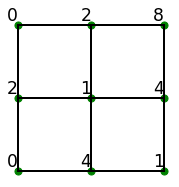

In [317]:
path = test_path_Naive(0,0,[],[],test_maze)
nodes, connectivity = plot_chosen_path(test_maze) # need to add options[path]

In [318]:
nodes

array([[0. , 3. ],
       [1.5, 3. ],
       [3. , 3. ],
       [0. , 1.5],
       [1.5, 1.5],
       [3. , 1.5],
       [0. , 0. ],
       [1.5, 0. ],
       [3. , 0. ]])

In [319]:
options[path]

[0, 2, 0, 4, 1]

In [320]:
option_coords[path]

[(0, 0), (1, 0), (2, 0), (2, 1), (2, 2)]

In [321]:
nodes_coords = np.split(nodes, height)
print(nodes_coords)

[array([[0. , 3. ],
       [1.5, 3. ],
       [3. , 3. ]]), array([[0. , 1.5],
       [1.5, 1.5],
       [3. , 1.5]]), array([[0. , 0. ],
       [1.5, 0. ],
       [3. , 0. ]])]


In [323]:
nodes_coords[2][2]

array([3., 0.])

In [51]:
connectivity

array([[0, 1, 3, 4],
       [1, 2, 4, 5],
       [3, 4, 6, 7],
       [4, 5, 7, 8]])